In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from config import technologies

In [2]:
df = pd.read_csv("./djinni/vacancies.csv", encoding="utf-8")
df.head(3)

,title,company,salary,category,publicated,description
0,Senior Application Developer - Python,techvision.global,$5000-6000,"Категорія: Python,Англійська: Upper-Intermedia...","Вакансія опублікована 8 березня 2023,2 перегля...",We improve the commerce experience by connecti...
1,Middle / Senior Python Engineer,Akvelon,NaN,"Категорія: Python,Англійська: Upper-Intermedia...","Вакансія опублікована 7 березня 2023,3 перегля...",is a file hosting service operated by the Amer...
2,Senior Python Developer,ADSH,NaN,"Категорія: Python,Англійська: Upper-Intermedia...","Вакансія опублікована 7 березня 2023,19 перегл...",We are seeking a talented Senior Back-End Deve...


In [3]:
df["experience"] = pd.Series([cat.split(",")[-1] for cat in df["category"]])
df["language"] = [
    cat.split(",")[1] if len(cat.split(",")) == 3 else None for cat in df["category"]
]
df["category"] = pd.Series([cat.split(",")[0] for cat in df["category"]])

In [4]:
df["view"] = pd.Series([cat.split(",")[1].split(" ")[0] for cat in df["publicated"]])
df["review"] = pd.Series([cat.split(",")[2].split(" ")[0] for cat in df["publicated"]])
df["review"] = df.review.astype("int")
df["publicated"] = pd.Series(
    [" ".join(cat.split(",")[0].split(" ")[2:]) for cat in df["publicated"]]
)

#  1. Technology popularity

In [5]:
tech = set([tech.lower() for tech in technologies])
df["descript"] = pd.Series(
    re.findall("[a-zA-Z]+", desc.lower()) for desc in df["description"]
)
df["technologies"] = pd.Series(
    ",".join(tech.intersection(set(desc))) for desc in df["descript"]
)
df = df.reindex(
    columns=[
        "title",
        "company",
        "salary",
        "technologies",
        "experience",
        "language",
        "publicated",
        "view",
        "review",
        "description",
        "descript",
        "category"
    ]
)
df.head(3)

,title,company,salary,technologies,experience,language,publicated,view,review,description,descript,category
0,Senior Application Developer - Python,techvision.global,$5000-6000,"docker,python,asyncio,aws,postgresql",5 років досвіду,Англійська: Upper-Intermediate,8 березня 2023,2,0,We improve the commerce experience by connecti...,"[we, improve, the, commerce, experience, by, c...",Категорія: Python
1,Middle / Senior Python Engineer,Akvelon,NaN,"aws,python",5 років досвіду,Англійська: Upper-Intermediate,7 березня 2023,3,3,is a file hosting service operated by the Amer...,"[is, a, file, hosting, service, operated, by, ...",Категорія: Python
2,Senior Python Developer,ADSH,NaN,"git,rest,django,python,api",3 роки досвіду,Англійська: Upper-Intermediate,7 березня 2023,19,2,We are seeking a talented Senior Back-End Deve...,"[we, are, seeking, a, talented, senior, back, ...",Категорія: Python


In [6]:
tech_ll = [tt for tt in df["technologies"]]
tech_ll.remove("")
tech_list = ",".join(tech_ll).split(",")
tech_set = list(set(tech_list))
tech_series = pd.Series(tech_list, name="tech")

In [7]:
tf = tech_series.to_frame()
tf_count = tf.groupby(by="tech")["tech"].count().to_frame(name="number")
tf_count.sort_values(by="number", ascending=False, inplace=True)

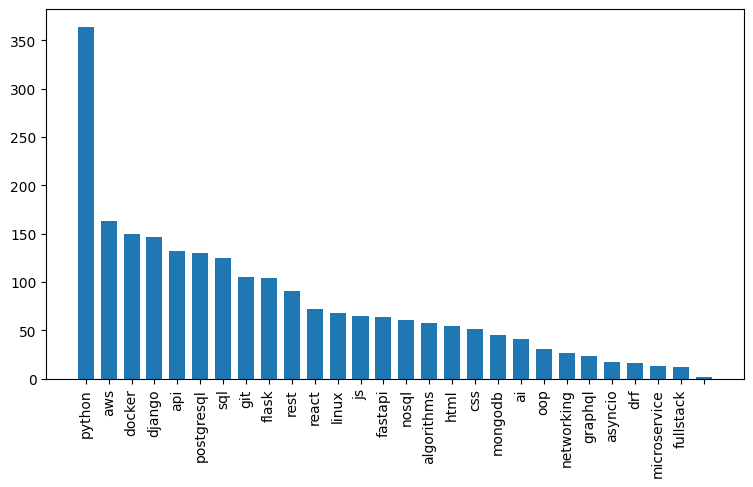

In [8]:
number = tf_count["number"].to_list()
technologies = tf_count.index.to_list()
fig, ax = plt.subplots()
fig.set_figwidth(9)
ax.bar(technologies, number, width=0.7)
plt.xticks(rotation=90)
plt.show()

# 2.    A vacancies for developers level

In [9]:
dflev = pd.DataFrame(index=df.index)
dflev["level"] = pd.Series([re.findall("[a-zA-Z]+", str(s).lower()) for s in df.title])
for i in range(dflev.shape[0]):
    for ll in dflev.loc[i]:
        flag = True
        for w in ll:
            if w in ("junior", "middle", "senior"):
                dflev.loc[i] = w
                flag = False
        if flag:
            dflev.loc[i] = "none level"
level = dflev.groupby("level")["level"].count().sort_values(ascending=False)
level

level
none level    165
senior        145
middle         57
junior         11
Name: level, dtype: int64

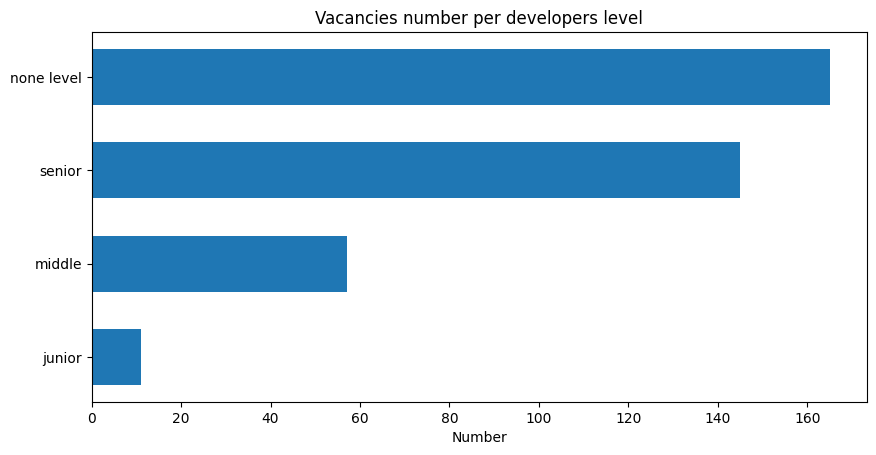

In [10]:
x_level = level.index
y_count = level.values
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.barh(x_level, y_count, height=0.6)
ax.invert_yaxis()
ax.set_xlabel("Number")
ax.set_title("Vacancies number per developers level")
plt.show()

#  3.  A vacancies by experience

In [11]:
tech_ll = [tt for tt in df["technologies"]]
tech_ll.remove("")
tech_list = ",".join(tech_ll).split(",")
tech_set = list(set(tech_list))
tech_series = pd.Series(tech_list, name="tech")
tf = tech_series.to_frame()
tf_count = tf.groupby(by="tech")["tech"].count().to_frame(name="number")
tf_count.sort_values(by="number", ascending=False, inplace=True)

In [12]:
dfl = pd.DataFrame(index=df.index)
dfl["title"] = df["title"]
dfl["experience"] = df["experience"]
dfl.head(3)

,title,experience
0,Senior Application Developer - Python,5 років досвіду
1,Middle / Senior Python Engineer,5 років досвіду
2,Senior Python Developer,3 роки досвіду


(-1.1, 1.1, -1.1, 1.1)

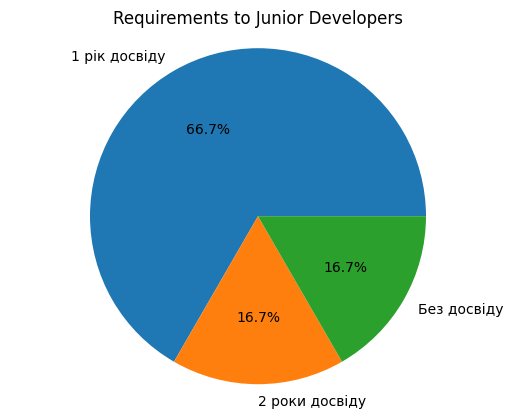

In [13]:
df_junior = dfl[dfl["title"].str.contains("unior")]
df_experience = (
    df_junior.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()
fig, ax = plt.subplots()
ax.set_title("Requirements to Junior Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.099999475658334,
 1.0999999750313492,
 -1.0999998863581446,
 1.0999989130936052)

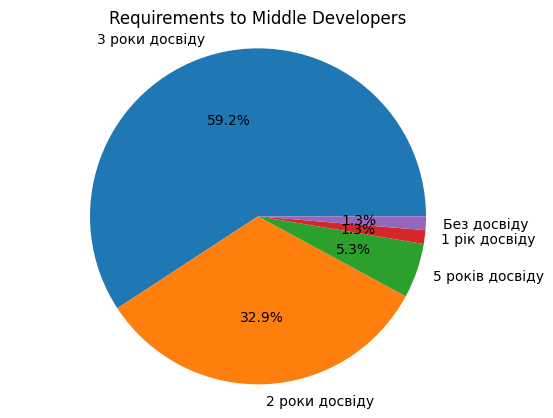

In [14]:
df_middle = dfl[dfl["title"].str.contains("iddle")]
df_experience = (
    df_middle.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to Middle Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.0999985769430398,
 1.0999999322353828,
 -1.0999942475130016,
 1.099998880067241)

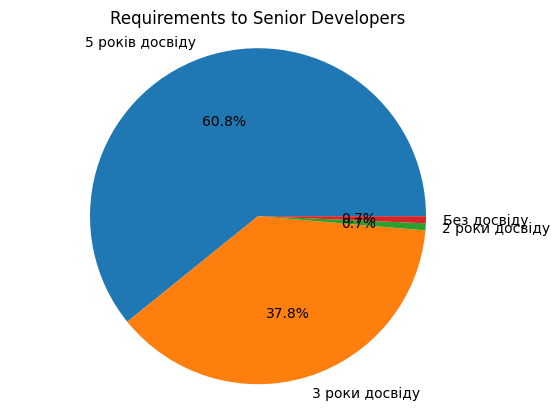

In [15]:
df_senior = dfl[dfl["title"].str.contains("enior")]
df_experience = (
    df_senior.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to Senior Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.0999996642519632,
 1.0999999840119983,
 -1.099998725543117,
 1.099993308027133)

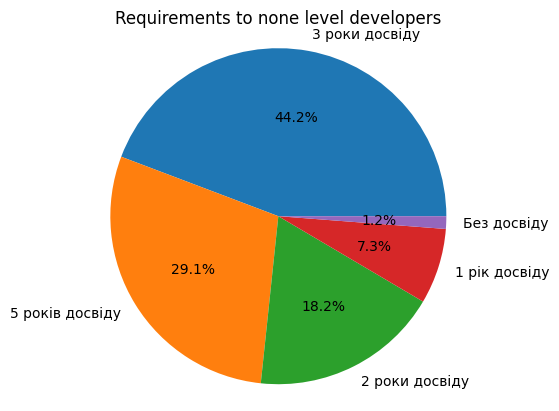

In [16]:
df_notlevel = dfl[
    ~dfl["title"].str.contains("unior")
    & ~dfl["title"].str.contains("iddle")
    & ~dfl["title"].str.contains("enior")
]
df_notlevel.head(10)
df_experience = (
    df_notlevel.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to none level developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")